In [1]:
from pathlib import Path
from functools import partial

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import mlflow
from scipy.ndimage import zoom
import torch
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="mlflow.utils.autologging_utils")

%load_ext autoreload
%autoreload 2
import pickle
import os, sys
import tqdm
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

/home/toc3/anaconda3/lib/python3.7/site-packages/requests/__init__.py:114: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4)/charset_normalizer (3.2.0) doesn't match a supported version!
  RequestsDependencyWarning,


In [2]:
from unxpass.databases import SQLiteDatabase
from unxpass.datasets import PassesDataset
from unxpass.components import pass_selection, pass_value, pass_success
from unxpass.components.utils import load_model
from unxpass.visualization import plot_action
from unxpass.ratings import CreativeDecisionRating
from unxpass import features

plt_settings = {"cmap": "magma", "vmin": 0, "vmax": 1, "interpolation": "bilinear"}

/home/toc3/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 데이터셋 로딩

In [3]:
train_DB_PATH = Path("../stores/train-database.sqlite")
train_db = SQLiteDatabase(train_DB_PATH)

test_DB_PATH = Path("../stores/test-database.sqlite")
test_db = SQLiteDatabase(test_DB_PATH)

In [4]:
STORES_FP = Path("../stores")

dataset_train = partial(PassesDataset, path=STORES_FP / "datasets" / "default" / "train")
dataset_test = partial(PassesDataset, path=STORES_FP / "datasets" / "default" / "test")


### Model loading

- loss를 구할 때, End-Destination의 pixel값을 바탕으로 학습함
- success는 15channel, selection는 12channel

In [5]:
def load_surface(path):
    path = './pass-surface/' + path + '.pkl'
    with open(path, 'rb') as f:
        surface = pickle.load(f)
    return surface

In [6]:
surface_selection = load_surface(path='End_pass_selection')
surface_success = load_surface(path='End_pass_Success')
surface9_success = load_surface(path='End9_pass_Success')
Intended_surface_selection = load_surface(path='Intended_pass_selection')
Intended_surface_success = load_surface(path='Intended_pass_Success')
Intended9_surface_success = load_surface(path='Intended9_pass_Success')

base_surface_success = load_surface(path='baseEnd_pass_Success')
base_Intended_surface_success = load_surface(path='baseIntended_pass_Success')

In [7]:
print(test_db.games(competition_id=43,season_id=106).index)
print(test_db.games(competition_id=55,season_id=43).index)
print(surface_selection.keys())
print(surface_selection[3869685].keys())

Int64Index([3857254, 3857260, 3857262, 3857265, 3857267, 3857277, 3857279,
            3857289, 3857291, 3857300, 3869118, 3869519, 3869685],
           dtype='int64', name='game_id')
Int64Index([3788745, 3788748, 3788766, 3788768, 3788772, 3788774, 3788775,
            3794689, 3795187, 3795506],
           dtype='int64', name='game_id')
dict_keys([3788745, 3788748, 3788766, 3788768, 3788772, 3788774, 3788775, 3794689, 3795187, 3795506, 3857254, 3857260, 3857262, 3857265, 3857267, 3857277, 3857279, 3857289, 3857291, 3857300, 3869118, 3869519, 3869685])
dict_keys([0, 2, 8, 10, 12, 14, 16, 21, 23, 25, 27, 31, 33, 40, 47, 49, 54, 56, 58, 63, 65, 69, 71, 75, 82, 85, 87, 93, 100, 102, 109, 118, 120, 122, 126, 128, 130, 159, 168, 182, 184, 188, 231, 237, 248, 262, 280, 288, 290, 310, 314, 320, 322, 325, 329, 331, 335, 336, 338, 407, 409, 411, 417, 418, 422, 424, 426, 428, 432, 434, 436, 438, 440, 446, 448, 469, 485, 500, 502, 504, 505, 506, 508, 509, 511, 527, 537, 538, 543, 545, 568, 575, 

In [8]:
SAMPLE = (3869685, 2363)
surface_selection[SAMPLE[0]].keys()

dict_keys([0, 2, 8, 10, 12, 14, 16, 21, 23, 25, 27, 31, 33, 40, 47, 49, 54, 56, 58, 63, 65, 69, 71, 75, 82, 85, 87, 93, 100, 102, 109, 118, 120, 122, 126, 128, 130, 159, 168, 182, 184, 188, 231, 237, 248, 262, 280, 288, 290, 310, 314, 320, 322, 325, 329, 331, 335, 336, 338, 407, 409, 411, 417, 418, 422, 424, 426, 428, 432, 434, 436, 438, 440, 446, 448, 469, 485, 500, 502, 504, 505, 506, 508, 509, 511, 527, 537, 538, 543, 545, 568, 575, 587, 596, 610, 612, 613, 617, 638, 640, 642, 644, 648, 652, 653, 655, 659, 661, 663, 674, 680, 691, 693, 699, 703, 704, 706, 712, 714, 716, 723, 724, 726, 728, 730, 731, 733, 735, 737, 739, 741, 745, 747, 751, 755, 756, 772, 773, 785, 786, 787, 789, 793, 795, 797, 799, 800, 802, 804, 806, 808, 810, 811, 813, 814, 816, 819, 820, 822, 824, 831, 833, 840, 854, 877, 881, 883, 888, 890, 892, 897, 909, 911, 913, 919, 921, 932, 957, 959, 970, 979, 981, 985, 987, 995, 1004, 1007, 1028, 1030, 1037, 1039, 1041, 1057, 1065, 1095, 1129, 1131, 1161, 1162, 1163, 1171,

In [9]:
key_list = list(surface_selection[SAMPLE[0]].keys())

In [10]:
final_df = test_db.actions(game_id=SAMPLE[0])
final_df

original_event_id  period_id  \
game_id action_id                                                    
3869685 0          f651a6c4-55e3-4e0f-a178-59414ba83d6a          1   
        1          9707e590-1d55-4d25-a50f-475019356152          1   
        2          a5956ecc-d637-44d2-8705-e2079e12013e          1   
        3          5ba6dfab-49f0-4225-bbb6-8b1e27bc729a          1   
        4          a511000a-bb39-4888-80e5-d81cabf8819e          1   
...                                                 ...        ...   
        2582       50dcde1a-faa3-4eec-a0cd-3f09a7cf763a          5   
        2583       54e27ba9-b9ae-44a3-ac8d-fc91e76a1b91          5   
        2584       bcc6d4ae-f71c-4566-bf2d-c12f910eb526          5   
        2585       59ebe83e-616a-4288-89fd-a0246b53d48f          5   
        2586       66eaf262-999f-4953-a924-f1b596de4dbf          5   

                   time_seconds  team_id  player_id    start_x    start_y  \
game_id action_id                                                           
3869685 0                   0.0      771       5487  52.058824  33.655696   
        1                   1.0      771      10481  63.529412  36.324051   
        2                   2.0      771      10481  62.029412  36.668354   
        3                  16.0      779      29201  19.147059   0.000000   
        4                  17.0      779       7797  30.882353   4.131646   
...                         ...      ...        ...        ...        ...   
        2582              147.0      779       5743  94.500000  34.344304   
        2583              209.0      771      10481  10.500000  33.655696   
        2584              256.0      779      16308  94.500000  34.344304   
        2585              309.0      771      22097  10.500000  33.655696   
        2586              357.0      779      28263  94.500000  34.344304   

                        end_x      end_y  bodypart_id  type_id  result_id  \
game_id action_id                                                           
3869685 0           63.529412  36.324051            4        0          1   
        1           62.029412  36.668354            0       21          1   
        2           21.176471   0.688608            5        0          0   
        3           30.882353   4.131646            0        2          1   
        4           30.352941   3.959494            0       21          1   
...                       ...        ...          ...      ...        ...   
        2582       105.000000  34.086076            4       12          1   
        2583         0.000000  29.782278            5       12          0   
        2584       105.000000  36.496203            5       12          1   
        2585         0.000000  32.967089            5       12          1   
        2586       105.000000  36.237975            5       12          1   

                   possession_team_id play_pattern_name  under_pressure  \
game_id action_id                                                         
3869685 0                       771.0     From Kick Off               0   
        1                       771.0     From Kick Off               0   
        2                       771.0     From Kick Off               0   
        3                       779.0     From Throw In               0   
        4                       779.0     From Throw In               1   
...                               ...               ...             ...   
        2582                    779.0             Other               0   
        2583                    771.0             Other               0   
        2584                    779.0             Other               0   
        2585                    771.0             Other               0   
        2586                    779.0             Other               0   

                                                               extra  \
game_id action_id                                                      
386

,,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id,possession_team_id,play_pattern_name,under_pressure,extra,visible_area_360,in_visible_area_360,freeze_frame_360
3869685,747,65ef69f8-15b8-435b-b1ee-485c13e9c717,1,2269.0,779,5507,33.176471,65.934177,46.764706,62.146835,4,0,1,779.0,Regular Play,0,"{'pass': {'recipient': {'id': 27886, 'name': '...","[[33.77006349355896, 14.149582453756494], [13....",1,"[{'teammate': True, 'actor': False, 'keeper': ..."


away_idx :  False
away_idx :  False
away_idx :  False
away_idx :  False
away_idx :  False
away_idx :  False
away_idx :  False


Text(0.5, 1.0, 'Intended_surface_success')

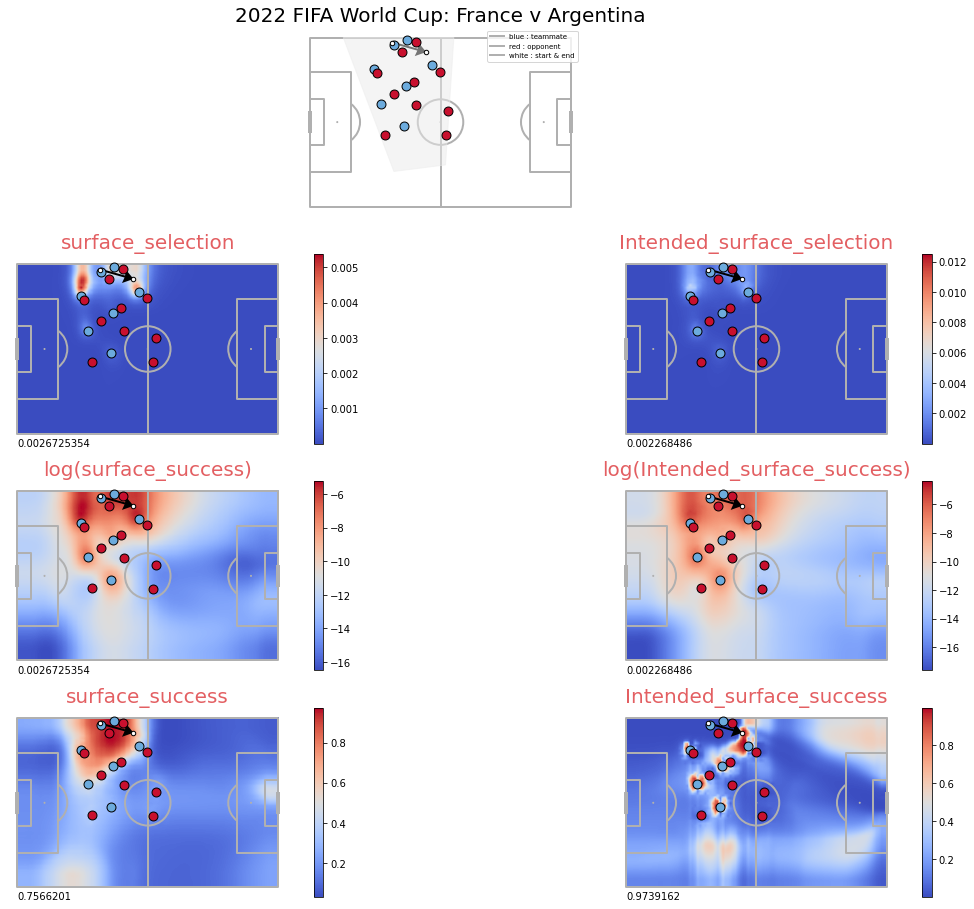

In [11]:
SAMPLE = (3869685, key_list[132])
home_team_id = test_db.get_home_away_team_id(game_id=SAMPLE[0])[0]
fig = plt.figure(figsize=(20, 16))

axes1 = fig.add_subplot(4, 1, 1)
axes2 = fig.add_subplot(4, 2, 3)
axes3 = fig.add_subplot(4, 2, 4)
axes4 = fig.add_subplot(4, 2, 5)
axes5 = fig.add_subplot(4, 2, 6)
axes6 = fig.add_subplot(4, 2, 7)
axes7 = fig.add_subplot(4, 2, 8)

ex_action = test_db.actions(game_id=SAMPLE[0]).loc[SAMPLE]
# ex_action = test_db.actions(game_id=SAMPLE[0])
# ex_action = play_left_to_right(ex_action).loc[SAMPLE]
display(ex_action.to_frame().T)

plot_action(ex_action, ax=axes1,home_team_id=home_team_id)

plot_action(
    ex_action, surface=surface_selection[SAMPLE[0]][SAMPLE[1]], 
    show_visible_area=False, show_action=True,
    ax=axes2, surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": plt.cm.get_cmap('coolwarm')},
    log_bool=False, home_team_id=home_team_id
)

plot_action(
    ex_action, surface=Intended_surface_selection[SAMPLE[0]][SAMPLE[1]], 
    show_visible_area=False, show_action=True,
    ax=axes3, surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": plt.cm.get_cmap('coolwarm')},
    log_bool=False, home_team_id=home_team_id
)

plot_action(
    ex_action, surface=surface_selection[SAMPLE[0]][SAMPLE[1]], 
    show_visible_area=False, show_action=True,
    ax=axes4, surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": plt.cm.get_cmap('coolwarm')},
    log_bool=True, home_team_id=home_team_id
)

plot_action(
    ex_action, surface=Intended_surface_selection[SAMPLE[0]][SAMPLE[1]], 
    show_visible_area=False, show_action=True,
    ax=axes5, surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": plt.cm.get_cmap('coolwarm')},
    log_bool=True, home_team_id=home_team_id
)

plot_action(
    ex_action, surface=surface_success[SAMPLE[0]][SAMPLE[1]], 
    show_visible_area=False, show_action=True,
    ax=axes6, surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": plt.cm.get_cmap('coolwarm')},
    log_bool=False, home_team_id=home_team_id
)

plot_action(
    ex_action, surface=Intended_surface_success[SAMPLE[0]][SAMPLE[1]], 
    show_visible_area=False, show_action=True,
    ax=axes7, surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": plt.cm.get_cmap('coolwarm')},
    log_bool=False, home_team_id=home_team_id
)

axes1.set_title("2022 FIFA World Cup: France v Argentina",fontsize=20)
axes2.set_title("surface_selection",color='#e35f62',fontsize=20)
axes3.set_title("Intended_surface_selection",color='#e35f62',fontsize=20)
axes4.set_title("log(surface_success)",color='#e35f62',fontsize=20)
axes5.set_title("log(Intended_surface_success)",color='#e35f62',fontsize=20)
axes6.set_title("surface_success",color='#e35f62',fontsize=20)
axes7.set_title("Intended_surface_success",color='#e35f62',fontsize=20)


In [12]:
print(surface_selection[3869685].keys())

dict_keys([0, 2, 8, 10, 12, 14, 16, 21, 23, 25, 27, 31, 33, 40, 47, 49, 54, 56, 58, 63, 65, 69, 71, 75, 82, 85, 87, 93, 100, 102, 109, 118, 120, 122, 126, 128, 130, 159, 168, 182, 184, 188, 231, 237, 248, 262, 280, 288, 290, 310, 314, 320, 322, 325, 329, 331, 335, 336, 338, 407, 409, 411, 417, 418, 422, 424, 426, 428, 432, 434, 436, 438, 440, 446, 448, 469, 485, 500, 502, 504, 505, 506, 508, 509, 511, 527, 537, 538, 543, 545, 568, 575, 587, 596, 610, 612, 613, 617, 638, 640, 642, 644, 648, 652, 653, 655, 659, 661, 663, 674, 680, 691, 693, 699, 703, 704, 706, 712, 714, 716, 723, 724, 726, 728, 730, 731, 733, 735, 737, 739, 741, 745, 747, 751, 755, 756, 772, 773, 785, 786, 787, 789, 793, 795, 797, 799, 800, 802, 804, 806, 808, 810, 811, 813, 814, 816, 819, 820, 822, 824, 831, 833, 840, 854, 877, 881, 883, 888, 890, 892, 897, 909, 911, 913, 919, 921, 932, 957, 959, 970, 979, 981, 985, 987, 995, 1004, 1007, 1028, 1030, 1037, 1039, 1041, 1057, 1065, 1095, 1129, 1131, 1161, 1162, 1163, 1171,

,,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id,possession_team_id,play_pattern_name,under_pressure,extra,visible_area_360,in_visible_area_360,freeze_frame_360
3869685,0,f651a6c4-55e3-4e0f-a178-59414ba83d6a,1,0.0,771,5487,52.058824,33.655696,63.529412,36.324051,4,0,1,771.0,From Kick Off,0,"{'pass': {'recipient': {'id': 10481, 'name': '...","[[7.483190557253346, 0.0], [35.891343941134586...",1,"[{'teammate': True, 'actor': False, 'keeper': ..."


away_idx :  True
away_idx :  True
away_idx :  True
away_idx :  True
away_idx :  True
away_idx :  True
away_idx :  True


Text(0.5, 1.0, 'un-xPass Intended SoccerMap(channel=15)')

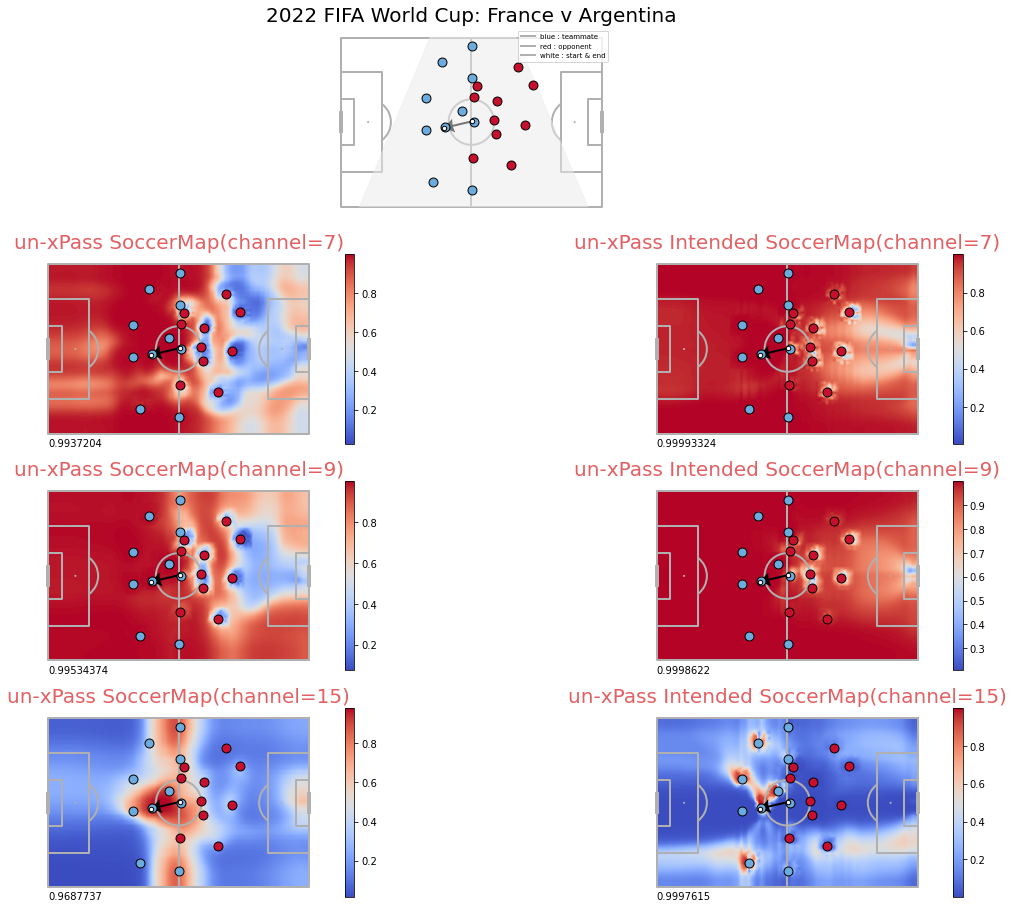

In [22]:
SAMPLE = (3869685, key_list[0])
home_team_id = test_db.get_home_away_team_id(game_id=SAMPLE[0])[0]
fig = plt.figure(figsize=(20, 16))

axes1 = fig.add_subplot(4, 1, 1)
axes2 = fig.add_subplot(4, 2, 3)
axes3 = fig.add_subplot(4, 2, 4)
axes4 = fig.add_subplot(4, 2, 5)
axes5 = fig.add_subplot(4, 2, 6)
axes6 = fig.add_subplot(4, 2, 7)
axes7 = fig.add_subplot(4, 2, 8)

ex_action = test_db.actions(game_id=SAMPLE[0]).loc[SAMPLE]
# ex_action = test_db.actions(game_id=SAMPLE[0])
# ex_action = play_left_to_right(ex_action).loc[SAMPLE]
display(ex_action.to_frame().T)

plot_action(ex_action, ax=axes1,home_team_id=home_team_id)

plot_action(
    ex_action, surface=base_surface_success[SAMPLE[0]][SAMPLE[1]], 
    show_visible_area=False, show_action=True,
    ax=axes2, surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": plt.cm.get_cmap('coolwarm')},
    log_bool=False, home_team_id=home_team_id
)

plot_action(
    ex_action, surface=base_Intended_surface_success[SAMPLE[0]][SAMPLE[1]], 
    show_visible_area=False, show_action=True,
    ax=axes3, surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": plt.cm.get_cmap('coolwarm')},
    log_bool=False, home_team_id=home_team_id
)

plot_action(
    ex_action, surface=surface9_success[SAMPLE[0]][SAMPLE[1]], 
    show_visible_area=False, show_action=True,
    ax=axes4, surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": plt.cm.get_cmap('coolwarm')},
    log_bool=False, home_team_id=home_team_id
)

plot_action(
    ex_action, surface=Intended9_surface_success[SAMPLE[0]][SAMPLE[1]], 
    show_visible_area=False, show_action=True,
    ax=axes5, surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": plt.cm.get_cmap('coolwarm')},
    log_bool=False, home_team_id=home_team_id
)

plot_action(
    ex_action, surface=surface_success[SAMPLE[0]][SAMPLE[1]], 
    show_visible_area=False, show_action=True,
    ax=axes6, surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": plt.cm.get_cmap('coolwarm')},
    log_bool=False, home_team_id=home_team_id
)

plot_action(
    ex_action, surface=Intended_surface_success[SAMPLE[0]][SAMPLE[1]], 
    show_visible_area=False, show_action=True,
    ax=axes7, surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": plt.cm.get_cmap('coolwarm')},
    log_bool=False, home_team_id=home_team_id
)

axes1.set_title("2022 FIFA World Cup: France v Argentina",fontsize=20)
axes2.set_title("un-xPass SoccerMap(channel=7)",color='#e35f62',fontsize=20)
axes3.set_title("un-xPass Intended SoccerMap(channel=7)",color='#e35f62',fontsize=20)
axes4.set_title("un-xPass SoccerMap(channel=9)",color='#e35f62',fontsize=20)
axes5.set_title("un-xPass Intended SoccerMap(channel=9)",color='#e35f62',fontsize=20)
axes6.set_title("un-xPass SoccerMap(channel=15)",color='#e35f62',fontsize=20)
axes7.set_title("un-xPass Intended SoccerMap(channel=15)",color='#e35f62',fontsize=20)


In [ ]:
surface_selection[3869685].keys()

dict_keys([0, 2, 8, 10, 12, 14, 16, 21, 23, 25, 27, 31, 33, 40, 47, 49, 54, 56, 58, 63, 65, 69, 71, 75, 82, 85, 87, 93, 100, 102, 109, 118, 120, 122, 126, 128, 130, 159, 168, 182, 184, 188, 231, 237, 248, 262, 280, 288, 290, 310, 314, 320, 322, 325, 329, 331, 335, 336, 338, 407, 409, 411, 417, 418, 422, 424, 426, 428, 432, 434, 436, 438, 440, 446, 448, 469, 485, 500, 502, 504, 505, 506, 508, 509, 511, 527, 537, 538, 543, 545, 568, 575, 587, 596, 610, 612, 613, 617, 638, 640, 642, 644, 648, 652, 653, 655, 659, 661, 663, 674, 680, 691, 693, 699, 703, 704, 706, 712, 714, 716, 723, 724, 726, 728, 730, 731, 733, 735, 737, 739, 741, 745, 747, 751, 755, 756, 772, 773, 785, 786, 787, 789, 793, 795, 797, 799, 800, 802, 804, 806, 808, 810, 811, 813, 814, 816, 819, 820, 822, 824, 831, 833, 840, 854, 877, 881, 883, 888, 890, 892, 897, 909, 911, 913, 919, 921, 932, 957, 959, 970, 979, 981, 985, 987, 995, 1004, 1007, 1028, 1030, 1037, 1039, 1041, 1057, 1065, 1095, 1129, 1131, 1161, 1162, 1163, 1171,

### Model loading

- loss를 구할 때, Intedned-End-Destination의 pixel값을 바탕으로 학습함
- success는 15channel, selection는 12channel

In [ ]:
Intended_model_pass_success = pass_success.SoccerMapComponent(
    pass_success.PytorchSoccerMapModel()) 

Intended_model_pass_success.train(dataset_train)
Intended_metric_pass_success = Intended_model_pass_success.test(dataset_test)
print("pass success : ",Intended_metric_pass_success)

In [ ]:
Intended_model_pass_selection = pass_selection.SoccerMapComponent(
    pass_selection.PytorchSoccerMapModel()) 

Intended_model_pass_selection.train(dataset_train)
Intended_metric_pass_selection = Intended_model_pass_selection.test(dataset_test)
print("pass selection : ",Intended_metric_pass_selection)

In [ ]:
Intended_surface_selection = Intended_model_pass_selection.predict_surface(dataset_test)

In [ ]:
Intended_surface_success = Intended_model_pass_success.predict_surface(dataset_test)

### 예시 경기 데이터 시각화

In [18]:
# Select an example pass
SAMPLE = (3857279, 1883)

In [19]:
surface_selection[SAMPLE[0]].keys()

dict_keys([0, 2, 4, 6, 8, 9, 11, 13, 17, 18, 20, 22, 24, 26, 28, 31, 33, 35, 37, 68, 70, 88, 90, 113, 115, 117, 121, 123, 125, 127, 132, 134, 136, 138, 140, 144, 146, 161, 165, 190, 194, 225, 235, 237, 242, 244, 246, 247, 256, 258, 279, 281, 283, 285, 287, 288, 293, 295, 297, 299, 301, 303, 304, 306, 310, 313, 315, 319, 324, 328, 330, 341, 343, 347, 349, 366, 368, 370, 371, 383, 389, 391, 392, 394, 396, 398, 400, 404, 406, 411, 413, 418, 420, 422, 424, 426, 428, 430, 432, 434, 435, 437, 439, 446, 447, 449, 450, 451, 453, 461, 468, 472, 474, 476, 478, 482, 488, 510, 512, 523, 524, 526, 528, 530, 532, 534, 537, 539, 547, 549, 551, 553, 555, 561, 565, 566, 568, 570, 575, 577, 579, 583, 585, 587, 589, 597, 601, 606, 608, 620, 621, 625, 627, 629, 633, 635, 636, 637, 639, 643, 645, 649, 650, 661, 663, 665, 667, 669, 671, 673, 675, 677, 681, 683, 687, 689, 691, 702, 704, 709, 711, 713, 727, 729, 731, 733, 739, 741, 748, 750, 752, 756, 758, 760, 764, 766, 767, 771, 773, 775, 777, 779, 780, 782

,,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id,possession_team_id,play_pattern_name,under_pressure,extra,visible_area_360,in_visible_area_360,freeze_frame_360
3857279,1883,55768f0c-e181-473e-a359-82b190988527,2,1947.0,771,5487,45.0,45.706329,55.235294,45.534177,4,0,1,771.0,Regular Play,0,"{'pass': {'recipient': {'id': 3009, 'name': 'K...","[[10.607456542629539, 0.0], [35.33313403364858...",1,"[{'teammate': True, 'actor': False, 'keeper': ..."


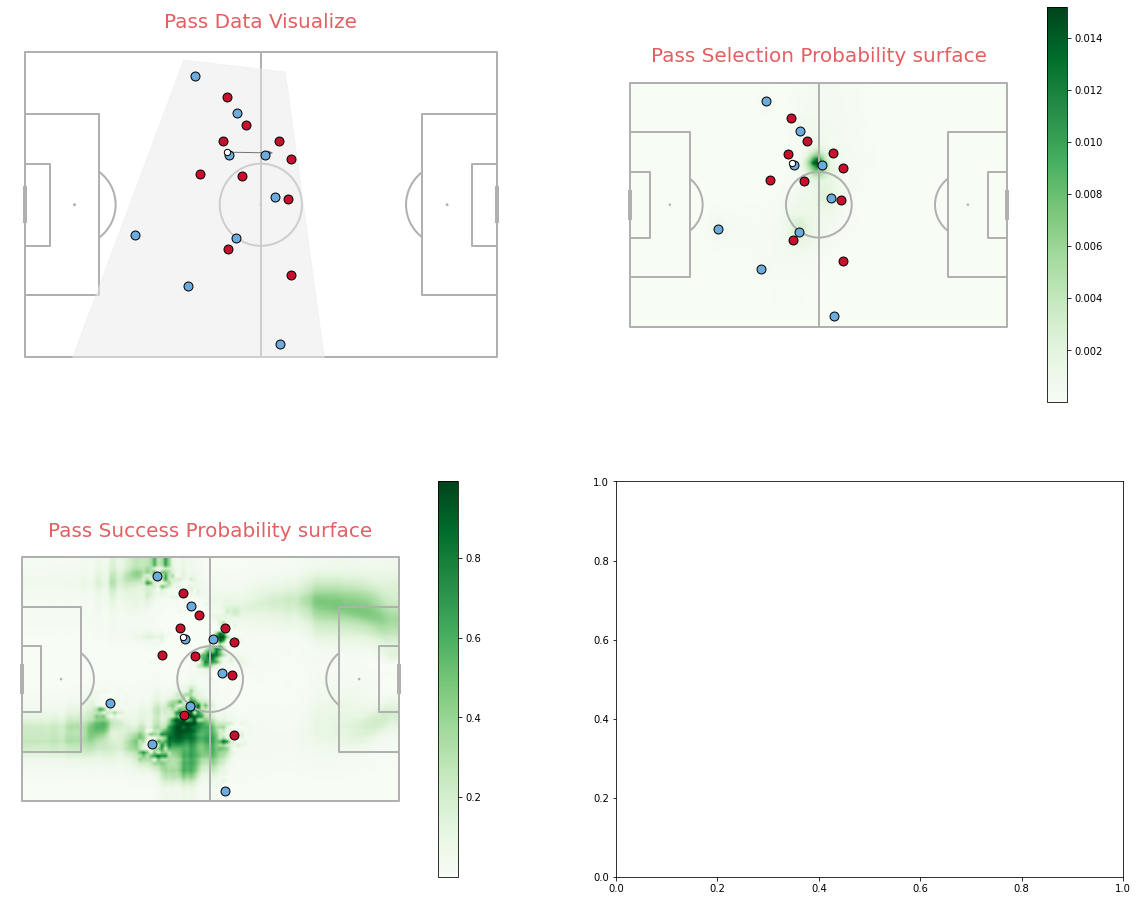

In [21]:
SAMPLE = (3857279, 1883)
fig, ax = plt.subplots(2,2,figsize=(20,16))

ex_action = test_db.actions(game_id=SAMPLE[0]).loc[SAMPLE]
display(ex_action.to_frame().T)

plot_action(ex_action, ax=ax[0,0])
plot_action(
    ex_action, surface=surface_selection[SAMPLE[0]][SAMPLE[1]], 
    show_visible_area=False, show_action=False,
    ax=ax[0,1], surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": "Greens"}
)

plot_action(
    ex_action, surface=surface_success[SAMPLE[0]][SAMPLE[1]], 
    show_visible_area=False, show_action=False,
    ax=ax[1,0], surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": "Greens"}
)

# plot_action(
#     ex_action, surface=surface_pass_value[SAMPLE[0]][SAMPLE[1]], 
#     show_visible_area=False, show_action=False,
#     ax=ax[1,1], surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": "Greens"}
# )

ax[0,0].set_title("Pass Data Visualize",color='#e35f62',fontsize=20)
ax[0,1].set_title("Pass Selection Probability surface",color='#e35f62',fontsize=20)
ax[1,0].set_title("Pass Success Probability surface",color='#e35f62',fontsize=20)
#ax[1,1].set_title("Pass Value Probability surface",color='#e35f62',fontsize=20)
plt.show()

In [ ]:
End_model_pass_success = pass_success.SoccerMapComponent(
    pass_success.PytorchSoccerMapModel()) 

End_model_pass_success.train(dataset_train)
End_metric_pass_success = End_model_pass_success.test(dataset_test)
print("End_pass success : ",End_metric_pass_success)

In [ ]:
IntendEnd_model_pass_selection = pass_selection.SoccerMapComponent(
    pass_selection.PytorchSoccerMapModel()) 

IntendEnd_model_pass_selection.train(dataset_train)
IntendEnd_metric_pass_selection = IntendEnd_model_pass_selection.test(dataset_test)
print("End_pass selection : ",IntendEnd_metric_pass_selection)

### Pass Selection probability Surface

In [ ]:
surface_pass_selection = model_pass_selection.predict_surface(dataset_test)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

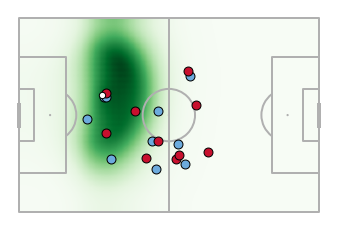

In [ ]:
fig, ax = plt.subplots()

ax = plot_action(
    ex_action, surface=surface_pass_selection[SAMPLE[0]][SAMPLE[1]], 
    show_visible_area=False, show_action=False,
    ax=ax, surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": "Greens"}
)

plt.show()

### Pass Success probability Surface

In [ ]:
surface_pass_success = model_pass_success.predict_surface(dataset_test)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

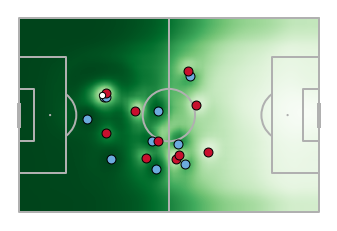

In [ ]:
fig, ax = plt.subplots()

ax = plot_action(
    ex_action, surface=surface_pass_success[SAMPLE[0]][SAMPLE[1]], 
    show_visible_area=False, show_action=False,
    ax=ax, surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": "Greens"}
)

plt.show()

### Pass Value probability Surface

In [ ]:
surface_pass_value = model_pass_value.predict_surface(dataset_test)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

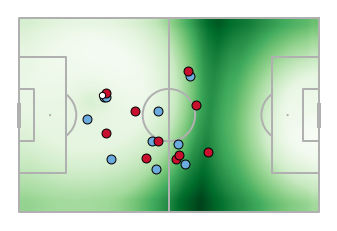

In [ ]:
fig, ax = plt.subplots()

ax = plot_action(
    ex_action, surface=surface_pass_value[SAMPLE[0]][SAMPLE[1]], 
    show_visible_area=False, show_action=False,
    ax=ax, surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": "Greens"}
)

plt.show()